# Today we will tune tree models and explore various metrics
We will use **leaf_absorbance** data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap, xgboost, pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Prepare data

In [2]:
data = pd.read_excel('3011979_datasets.xlsx', sheet_name = 'leaf_absorbance', index_col = None)
data = data.loc[~pd.isna(data).any(axis = 1)]
data.head()

,ConditionID,CultivarID,Pi,324,334,344,354,364,374,384,...,694,704,714,724,734,744,754,764,774,784
0,1,1,86.223677,0.136531,0.077077,0.075083,0.061408,0.058935,0.054756,0.055509,...,0.129893,0.218741,0.304643,0.374003,0.414906,0.438958,0.445656,0.444957,0.447571,0.442941
1,1,1,104.792925,0.128571,0.092857,0.084086,0.055360,0.069373,0.050320,0.048282,...,0.117621,0.202819,0.291199,0.366811,0.410271,0.439536,0.443814,0.444727,0.444642,0.446600
2,1,1,167.335884,0.094961,0.128649,0.123823,0.066028,0.054652,0.049103,0.044307,...,0.136578,0.229855,0.320378,0.397110,0.440710,0.464248,0.473719,0.471862,0.472635,0.471684
3,1,1,215.911286,0.130802,0.087640,0.102281,0.085255,0.074521,0.064555,0.057626,...,0.138065,0.228084,0.316342,0.389543,0.429343,0.454860,0.458740,0.458078,0.461857,0.463952
4,1,1,223.691091,0.125862,0.089796,0.075459,0.095190,0.061393,0.070902,0.061411,...,0.131028,0.219312,0.309854,0.385228,0.429559,0.457268,0.462188,0.463328,0.463395,0.466131


In [3]:
condition_label = data['ConditionID']
pi_content = data['Pi']
input_data = data.iloc[:, 3:]

print('input data shape:', input_data.shape)

input data shape: (3094, 47)


## Withhold 20% as test data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(input_data, condition_label, test_size = 0.2,
                                                    stratify = condition_label, random_state = 3011979)

X_scaler = StandardScaler(with_mean = True, with_std = True).fit(X_train)
X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

print('training size:', X_train.shape[0])
print('test size:', X_test.shape[0])

training size: 2475
test size: 619


## Use GridSearchCV to tune Random Forest models
Choices of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [5]:
base_rf = RandomForestClassifier(n_estimators = 500, random_state = 3011979)
param_grid = {'max_features': [0.3, 0.6], ## fraction of features considered
              'max_depth': [10, None], ## tree depth
              'min_samples_split': [2, 10]} ## minimum number of samples at each split

grid_rf = GridSearchCV(estimator = base_rf, param_grid = param_grid,
                       scoring = ['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                       refit = False, cv = 5)

In [6]:
grid_rf.fit(X_train_std, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=500,
                                              random_state=3011979),
             param_grid={'max_depth': [10, None], 'max_features': [0.3, 0.6],
                         'min_samples_split': [2, 10]},
             refit=False,
             scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'])

## Use pickle to save past tuning result

In [7]:
pickle.dump(grid_rf, open('L8_random-forest_grid-search_result.pkl', 'wb'))
grid_rf = pickle.load(open('L8_random-forest_grid-search_result.pkl', 'rb'))

## View tuning result

In [8]:
grid_rf.cv_results_

{'mean_fit_time': array([11.21881576, 10.82834606, 21.55833287, 20.34395704, 13.63057594,
        13.71483493, 26.74904609, 28.63643765]),
 'std_fit_time': array([0.88405062, 1.13735806, 1.01438086, 1.91196022, 1.64416891,
        0.804654  , 1.472932  , 3.13395227]),
 'mean_score_time': array([0.34447742, 0.25583997, 0.42973008, 0.26302171, 0.32111278,
        0.33641934, 0.32624712, 0.40762911]),
 'std_score_time': array([0.1140109 , 0.0176775 , 0.25244736, 0.01156948, 0.03510568,
        0.05693841, 0.01577488, 0.08907455]),
 'param_max_depth': masked_array(data=[10, 10, 10, 10, None, None, None, None],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[0.3, 0.3, 0.6, 0.6, 0.3, 0.3, 0.6, 0.6],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data

In [9]:
grid_rf_result = pd.DataFrame.from_dict(grid_rf.cv_results_)
grid_rf_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_accuracy,split1_test_accuracy,...,std_test_f1_weighted,rank_test_f1_weighted,split0_test_roc_auc_ovr_weighted,split1_test_roc_auc_ovr_weighted,split2_test_roc_auc_ovr_weighted,split3_test_roc_auc_ovr_weighted,split4_test_roc_auc_ovr_weighted,mean_test_roc_auc_ovr_weighted,std_test_roc_auc_ovr_weighted,rank_test_roc_auc_ovr_weighted
0,11.218816,0.884051,0.344477,0.114011,10,0.3,2,"{'max_depth': 10, 'max_features': 0.3, 'min_sa...",0.682828,0.660606,...,0.009661,4,0.835331,0.837892,0.838592,0.849644,0.846952,0.841682,0.005575,5
1,10.828346,1.137358,0.255840,0.017677,10,0.3,10,"{'max_depth': 10, 'max_features': 0.3, 'min_sa...",0.680808,0.666667,...,0.007995,6,0.836276,0.839573,0.836403,0.848540,0.845498,0.841258,0.004944,6
2,21.558333,1.014381,0.429730,0.252447,10,0.6,2,"{'max_depth': 10, 'max_features': 0.6, 'min_sa...",0.676768,0.666667,...,0.008741,7,0.833149,0.839426,0.834896,0.848795,0.846464,0.840546,0.006180,7
3,20.343957,1.911960,0.263022,0.011569,10,0.6,10,"{'max_depth': 10, 'max_features': 0.6, 'min_sa...",0.678788,0.650505,...,0.013555,8,0.832753,0.836218,0.834730,0.848942,0.847267,0.839982,0.006743,8
4,13.630576,1.644169,0.321113,0.035106,None,0.3,2,"{'max_depth': None, 'max_features': 0.3, 'min_...",0.684848,0.662626,...,0.010830,3,0.843258,0.841913,0.834701,0.852258,0.849842,0.844394,0.006212,1


## Sort by best AUROC

In [10]:
temp = grid_rf_result.sort_values('rank_test_roc_auc_ovr_weighted')

display(temp[['mean_test_roc_auc_ovr_weighted', 'mean_test_f1_weighted', 'mean_test_accuracy']])
print(temp['params'].iloc[0])

,mean_test_roc_auc_ovr_weighted,mean_test_f1_weighted,mean_test_accuracy
4,0.844394,0.678002,0.677980
6,0.842685,0.681126,0.681616
7,0.841947,0.679113,0.679596
5,0.841719,0.675577,0.675556
0,0.841682,0.677596,0.677172
1,0.841258,0.674908,0.673939
2,0.840546,0.671641,0.670707
3,0.839982,0.669929,0.669091


{'max_depth': None, 'max_features': 0.3, 'min_samples_split': 2}


## Sort by best weighted f1

In [11]:
temp = grid_rf_result.sort_values('rank_test_f1_weighted')

display(temp[['mean_test_roc_auc_ovr_weighted', 'mean_test_f1_weighted', 'mean_test_accuracy']])
print(temp['params'].iloc[0])

,mean_test_roc_auc_ovr_weighted,mean_test_f1_weighted,mean_test_accuracy
6,0.842685,0.681126,0.681616
7,0.841947,0.679113,0.679596
4,0.844394,0.678002,0.677980
0,0.841682,0.677596,0.677172
5,0.841719,0.675577,0.675556
1,0.841258,0.674908,0.673939
2,0.840546,0.671641,0.670707
3,0.839982,0.669929,0.669091


{'max_depth': None, 'max_features': 0.6, 'min_samples_split': 2}


## Retrain model with the best hyperparameters

In [12]:
best_rf = RandomForestClassifier(n_estimators = 500, max_depth = None, max_features = 0.6, random_state = 3011979)
best_rf.fit(X_train_std, y_train)

## Predict probability of each class

In [13]:
predicted_rf = best_rf.predict_proba(X_test_std)
print(predicted_rf.shape)

(619, 3)


## Visualize ROC and PRC

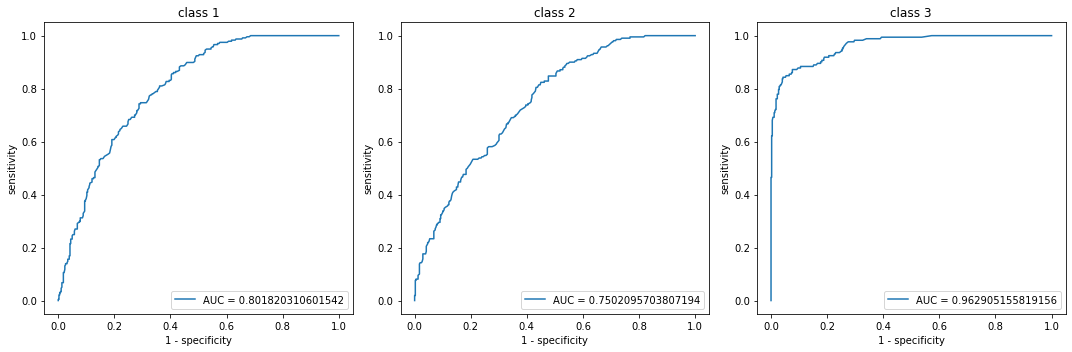

In [14]:
plt.figure(figsize = (15, 5))

for i in range(predicted_rf.shape[1]):
    plt.subplot(1, 3, i + 1)
    fpr, tpr, thresholds = roc_curve(y_test, predicted_rf[:, i], pos_label = (i + 1))
    plt.plot(fpr, tpr, label = 'AUC = ' + str(roc_auc_score(y_test == (i + 1), predicted_rf[:, i])))
    plt.title('class ' + str(i + 1))
    plt.legend(loc = 'lower right')
    plt.xlabel('1 - specificity'); plt.ylabel('sensitivity')

plt.tight_layout()
plt.show()

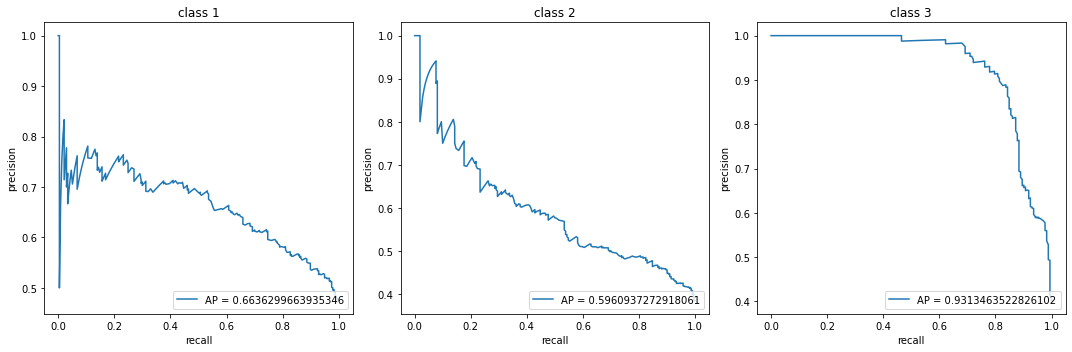

In [15]:
plt.figure(figsize = (15, 5))

for i in range(predicted_rf.shape[1]):
    plt.subplot(1, 3, i + 1)
    precision, recall, thresholds = precision_recall_curve(y_test, predicted_rf[:, i], pos_label = (i + 1))
    plt.plot(recall, precision, label = 'AP = ' + str(average_precision_score(y_test == (i + 1), predicted_rf[:, i])))
    plt.title('class ' + str(i + 1))
    plt.legend(loc = 'lower right')
    plt.xlabel('recall'); plt.ylabel('precision')

plt.tight_layout()
plt.show()

## Classification report

In [16]:
print(classification_report(y_test, np.argmax(predicted_rf, axis = 1) + 1))

              precision    recall  f1-score   support

           1       0.63      0.65      0.64       237
           2       0.57      0.52      0.54       210
           3       0.82      0.86      0.84       172

    accuracy                           0.67       619
   macro avg       0.67      0.68      0.67       619
weighted avg       0.66      0.67      0.66       619



## Confusion matrix

In [17]:
conf_mat = confusion_matrix(y_test, np.argmax(predicted_rf, axis = 1) + 1)
print(conf_mat)

[[155  69  13]
 [ 82 109  19]
 [ 10  14 148]]


## Use cross-validation to tune XGBoost models
GridSearchCV doesn't support **early stopping**

In [18]:
grid_xgb = {}
splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 3011979)

for mcw in [0.9, 0.8, 0.7]:
    for depth in [5, 10, 20]:
        for gamma in [0, 2]:
            name = 'MCW' + str(mcw) + '-D' + str(depth) + '-G' + str(gamma)
            grid_xgb[name] = {'iterations':[], 'accuracy':[], 'f1_weighted':[], 'roc_auc_ovr_weighted':[]}
            grid_xgb[name]['params'] = {'min_child_weight': mcw,
                                        'max_depth': depth,
                                        'gamma': gamma}
            base_xgb = xgboost.XGBClassifier(n_estimators = 200, use_label_encoder = False, tree_method = 'hist',
                                             objective = 'multi:softprob', eval_metric = 'mlogloss',
                                             min_child_weight = mcw, max_depth = depth, gamma = gamma)
            
            for train_index, val_index in splitter.split(X_train_std, y_train):
                X_train_local = X_train_std.iloc[train_index, :]
                X_val = X_train_std.iloc[val_index, :]
                
                y_train_local = y_train.iloc[train_index] - 1 ## XGBoost requires class label to start from 0
                y_val = y_train.iloc[val_index] - 1
                
                base_xgb.fit(X_train_local, y_train_local, early_stopping_rounds = 10,
                             eval_metric = 'mlogloss', verbose = False,
                             eval_set = [(X_train_local, y_train_local), (X_val, y_val)])
                predicted = base_xgb.predict_proba(X_val)
                predicted_class = base_xgb.predict(X_val)
                
                grid_xgb[name]['iterations'].append(base_xgb.best_iteration)
                grid_xgb[name]['accuracy'].append(accuracy_score(y_val, predicted_class))
                grid_xgb[name]['f1_weighted'].append(f1_score(y_val, predicted_class, average = 'weighted'))
                grid_xgb[name]['roc_auc_ovr_weighted'].append(roc_auc_score(y_val, predicted, 
                                                                            average = 'weighted',
                                                                            multi_class = 'ovr'))          

### Convert to DataFrame

In [19]:
grid_xgb_result = pd.DataFrame(0, index = grid_xgb.keys(), 
                               columns = ['params', 'iterations', 'accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'])

for name in grid_xgb:
    for field in grid_xgb[name]:
        if field == 'params':
            grid_xgb_result.loc[name, field] = str(grid_xgb[name][field])
        else:
            grid_xgb_result.loc[name, field] = np.mean(grid_xgb[name][field])

In [20]:
grid_xgb_result.head()

,params,iterations,accuracy,f1_weighted,roc_auc_ovr_weighted
MCW0.9-D5-G0,"{'min_child_weight': 0.9, 'max_depth': 5, 'gam...",21.8,0.680808,0.680933,0.842067
MCW0.9-D5-G2,"{'min_child_weight': 0.9, 'max_depth': 5, 'gam...",23.2,0.685657,0.686131,0.844932
MCW0.9-D10-G0,"{'min_child_weight': 0.9, 'max_depth': 10, 'ga...",14.0,0.675556,0.675300,0.835615
MCW0.9-D10-G2,"{'min_child_weight': 0.9, 'max_depth': 10, 'ga...",21.6,0.681616,0.681516,0.844503
MCW0.9-D20-G0,"{'min_child_weight': 0.9, 'max_depth': 20, 'ga...",12.2,0.675152,0.674037,0.833818


## View results sorted by AUROC

In [21]:
temp = grid_xgb_result.sort_values('roc_auc_ovr_weighted', ascending = False)

display(temp.head(5))
print(temp['params'].iloc[0])

,params,iterations,accuracy,f1_weighted,roc_auc_ovr_weighted
MCW0.8-D5-G0,"{'min_child_weight': 0.8, 'max_depth': 5, 'gam...",21.0,0.686465,0.686850,0.846106
MCW0.8-D5-G2,"{'min_child_weight': 0.8, 'max_depth': 5, 'gam...",28.2,0.677576,0.677254,0.845288
MCW0.7-D5-G2,"{'min_child_weight': 0.7, 'max_depth': 5, 'gam...",34.2,0.675152,0.675310,0.844985
MCW0.9-D5-G2,"{'min_child_weight': 0.9, 'max_depth': 5, 'gam...",23.2,0.685657,0.686131,0.844932
MCW0.9-D10-G2,"{'min_child_weight': 0.9, 'max_depth': 10, 'ga...",21.6,0.681616,0.681516,0.844503


{'min_child_weight': 0.8, 'max_depth': 5, 'gamma': 0}


## Add sample and feature bagging to the tuning

In [22]:
grid_xgb = {}

for colsample in [0.8, 0.7, 0.6]:
    for subsample in [1, 0.9, 0.8, 0.7]:
        name = 'CS' + str(colsample) + '-SS' + str(subsample)
        grid_xgb[name] = {'iterations':[], 'accuracy':[], 'f1_weighted':[], 'roc_auc_ovr_weighted':[]}
        grid_xgb[name]['params'] = {'colsample_bytree': colsample,
                                    'subsample': subsample}
        base_xgb = xgboost.XGBClassifier(n_estimators = 200, use_label_encoder = False, tree_method = 'hist',
                                         objective = 'multi:softprob', eval_metric = 'mlogloss',
                                         min_child_weight = 0.8, max_depth = 5, gamma = 0,
                                         colsample_bytree = colsample, subsample = subsample)
            
        for train_index, val_index in splitter.split(X_train_std, y_train):
            X_train_local = X_train_std.iloc[train_index, :]
            X_val = X_train_std.iloc[val_index, :]
                
            y_train_local = y_train.iloc[train_index] - 1 ## XGBoost requires class label to start from 0
            y_val = y_train.iloc[val_index] - 1
                
            base_xgb.fit(X_train_local, y_train_local, early_stopping_rounds = 10,
                         eval_metric = 'mlogloss', verbose = False,
                         eval_set = [(X_train_local, y_train_local), (X_val, y_val)])
            predicted = base_xgb.predict_proba(X_val)
            predicted_class = base_xgb.predict(X_val)
                
            grid_xgb[name]['iterations'].append(base_xgb.best_iteration)
            grid_xgb[name]['accuracy'].append(accuracy_score(y_val, predicted_class))
            grid_xgb[name]['f1_weighted'].append(f1_score(y_val, predicted_class, average = 'weighted'))
            grid_xgb[name]['roc_auc_ovr_weighted'].append(roc_auc_score(y_val, predicted, 
                                                                        average = 'weighted',
                                                                        multi_class = 'ovr'))        

In [23]:
grid_xgb_result_bootstrap = pd.DataFrame(0, index = grid_xgb.keys(), 
                                         columns = ['params', 'iterations', 'accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'])

for name in grid_xgb:
    for field in grid_xgb[name]:
        if field == 'params':
            grid_xgb_result_bootstrap.loc[name, field] = str(grid_xgb[name][field])
        else:
            grid_xgb_result_bootstrap.loc[name, field] = np.mean(grid_xgb[name][field])

In [24]:
# pickle.dump(grid_xgb_result_bootstrap, open('3011979_L9_031822_xgboost_grid-search_result_bootstrap.pkl', 'wb'))
# grid_xgb_result_bootstrap = pickle.load(open('3011979_L9_031822_xgboost_grid-search_result_bootstrap.pkl', 'rb'))
grid_xgb_result_bootstrap.head()

,params,iterations,accuracy,f1_weighted,roc_auc_ovr_weighted
CS0.8-SS1,"{'colsample_bytree': 0.8, 'subsample': 1}",25.4,0.684444,0.684829,0.845923
CS0.8-SS0.9,"{'colsample_bytree': 0.8, 'subsample': 0.9}",21.6,0.694949,0.695055,0.849734
CS0.8-SS0.8,"{'colsample_bytree': 0.8, 'subsample': 0.8}",21.4,0.690909,0.690660,0.850478
CS0.8-SS0.7,"{'colsample_bytree': 0.8, 'subsample': 0.7}",23.2,0.682020,0.682757,0.843143
CS0.7-SS1,"{'colsample_bytree': 0.7, 'subsample': 1}",26.4,0.678384,0.678763,0.845508


## Identify optimal bootstrap scheme

In [25]:
temp = grid_xgb_result_bootstrap.sort_values('roc_auc_ovr_weighted', ascending = False)

display(temp.head(5))
print(temp['params'].iloc[0])

,params,iterations,accuracy,f1_weighted,roc_auc_ovr_weighted
CS0.8-SS0.8,"{'colsample_bytree': 0.8, 'subsample': 0.8}",21.4,0.690909,0.690660,0.850478
CS0.8-SS0.9,"{'colsample_bytree': 0.8, 'subsample': 0.9}",21.6,0.694949,0.695055,0.849734
CS0.6-SS0.7,"{'colsample_bytree': 0.6, 'subsample': 0.7}",26.2,0.683232,0.683865,0.848618
CS0.7-SS0.7,"{'colsample_bytree': 0.7, 'subsample': 0.7}",25.8,0.690505,0.691053,0.847783
CS0.6-SS0.9,"{'colsample_bytree': 0.6, 'subsample': 0.9}",26.8,0.683636,0.683562,0.847756


{'colsample_bytree': 0.8, 'subsample': 0.8}


## Refit XGBoost using the best hyperparameters

In [26]:
best_xgb_perf = {'iterations':[], 'accuracy':[], 'f1_weighted':[], 'roc_auc_ovr_weighted':[]}
best_xgb = xgboost.XGBClassifier(n_estimators = 200, use_label_encoder = False, tree_method = 'hist',
                                 objective = 'multi:softprob', eval_metric = 'mlogloss',
                                 min_child_weight = 0.8, max_depth = 5, gamma = 0,
                                 colsample_bytree = 0.8, subsample = 0.8)

for train_index, val_index in splitter.split(X_train_std, y_train):
    X_train_local = X_train_std.iloc[train_index, :]
    X_val = X_train_std.iloc[val_index, :]
                
    y_train_local = y_train.iloc[train_index] - 1 ## XGBoost requires class label to start from 0
    y_val = y_train.iloc[val_index] - 1
                
    best_xgb.fit(X_train_local, y_train_local, early_stopping_rounds = 10,
                 eval_metric = 'mlogloss', verbose = False,
                 eval_set = [(X_train_local, y_train_local), (X_val, y_val)])
    predicted = best_xgb.predict_proba(X_val)
    predicted_class = best_xgb.predict(X_val)
                
    best_xgb_perf['iterations'].append(best_xgb.best_iteration)
    best_xgb_perf['accuracy'].append(accuracy_score(y_val, predicted_class))
    best_xgb_perf['f1_weighted'].append(f1_score(y_val, predicted_class, average = 'weighted'))
    best_xgb_perf['roc_auc_ovr_weighted'].append(roc_auc_score(y_val, predicted, 
                                                                average = 'weighted',
                                                                multi_class = 'ovr'))
#     best_xgb_perf['learning_curve'].append(best_xgb.evals_result_)

In [27]:
for metric in best_xgb_perf:
    print('average', metric, '=', np.mean(best_xgb_perf[metric]))

average iterations = 21.4
average accuracy = 0.6909090909090908
average f1_weighted = 0.6906596187025883
average roc_auc_ovr_weighted = 0.8504784777995923


In [28]:
best_xgb_perf['roc_auc_ovr_weighted']

[0.8313025058662763,
 0.8641133925537595,
 0.8639616770935353,
 0.8532593202144205,
 0.8397554932699698]

## Visualize training curves (from last CV fold)

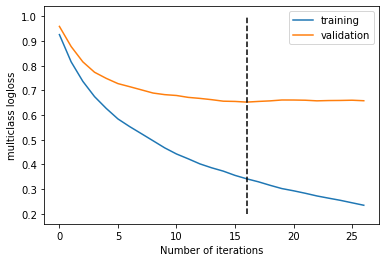

In [29]:
num_epoch = len(best_xgb.evals_result_['validation_0']['mlogloss'])

plt.plot(range(num_epoch), best_xgb.evals_result_['validation_0']['mlogloss'], label = 'training')
plt.plot(range(num_epoch), best_xgb.evals_result_['validation_1']['mlogloss'], label = 'validation')
plt.legend()
plt.plot([best_xgb.best_iteration, best_xgb.best_iteration], [0.2, 1.0], '--k')
plt.xlabel('Number of iterations'); plt.ylabel('multiclass logloss')
plt.show()

## Try reducing learning rate (from 1.0 to 0.1)

In [30]:
best_xgb_perf = {'iterations':[], 'accuracy':[], 'f1_weighted':[], 'roc_auc_ovr_weighted':[]}
best_xgb = xgboost.XGBClassifier(n_estimators = 200, use_label_encoder = False, tree_method = 'hist',
                                 objective = 'multi:softprob', eval_metric = 'mlogloss',
                                 min_child_weight = 0.8, max_depth = 5, gamma = 0,
                                 colsample_bytree = 0.8, subsample = 0.8, learning_rate = 0.1)

for train_index, val_index in splitter.split(X_train_std, y_train):
    X_train_local = X_train_std.iloc[train_index, :]
    X_val = X_train_std.iloc[val_index, :]
                
    y_train_local = y_train.iloc[train_index] - 1 ## XGBoost requires class label to start from 0
    y_val = y_train.iloc[val_index] - 1
                
    best_xgb.fit(X_train_local, y_train_local, early_stopping_rounds = 10,
                 eval_metric = 'mlogloss', verbose = False,
                 eval_set = [(X_train_local, y_train_local), (X_val, y_val)])
    predicted = best_xgb.predict_proba(X_val)
    predicted_class = best_xgb.predict(X_val)
                
    best_xgb_perf['iterations'].append(best_xgb.best_iteration)
    best_xgb_perf['accuracy'].append(accuracy_score(y_val, predicted_class))
    best_xgb_perf['f1_weighted'].append(f1_score(y_val, predicted_class, average = 'weighted'))
    best_xgb_perf['roc_auc_ovr_weighted'].append(roc_auc_score(y_val, predicted, 
                                                                average = 'weighted',
                                                                multi_class = 'ovr'))

In [31]:
for metric in best_xgb_perf:
    print('average', metric, '=', np.mean(best_xgb_perf[metric]))

average iterations = 74.0
average accuracy = 0.6933333333333334
average f1_weighted = 0.6932888161329923
average roc_auc_ovr_weighted = 0.8509840202352018


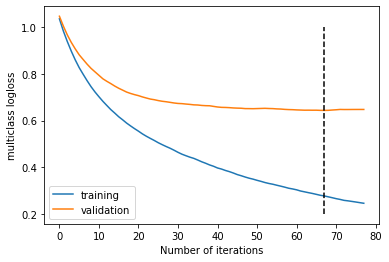

In [32]:
num_epoch = len(best_xgb.evals_result_['validation_0']['mlogloss'])

plt.plot(range(num_epoch), best_xgb.evals_result_['validation_0']['mlogloss'], label = 'training')
plt.plot(range(num_epoch), best_xgb.evals_result_['validation_1']['mlogloss'], label = 'validation')
plt.legend()
plt.plot([best_xgb.best_iteration, best_xgb.best_iteration], [0.2, 1.0], '--k')
plt.xlabel('Number of iterations'); plt.ylabel('multiclass logloss')
plt.show()

## Further reduce learning rate (from 0.1 to 0.01)
Increase the number of iterations, **n_estimators** and **early_stopping_rounds**, accordingly

In [33]:
best_xgb_perf = {'iterations':[], 'accuracy':[], 'f1_weighted':[], 'roc_auc_ovr_weighted':[]}
best_xgb = xgboost.XGBClassifier(n_estimators = 1000, use_label_encoder = False, tree_method = 'hist',
                                 objective = 'multi:softprob', eval_metric = 'mlogloss',
                                 min_child_weight = 0.8, max_depth = 5, gamma = 0,
                                 colsample_bytree = 0.8, subsample = 0.8, learning_rate = 0.01)

for train_index, val_index in splitter.split(X_train_std, y_train):
    X_train_local = X_train_std.iloc[train_index, :]
    X_val = X_train_std.iloc[val_index, :]
                
    y_train_local = y_train.iloc[train_index] - 1 ## XGBoost requires class label to start from 0
    y_val = y_train.iloc[val_index] - 1
                
    best_xgb.fit(X_train_local, y_train_local, early_stopping_rounds = 50,
                 eval_metric = 'mlogloss', verbose = False,
                 eval_set = [(X_train_local, y_train_local), (X_val, y_val)])
    predicted = best_xgb.predict_proba(X_val)
    predicted_class = best_xgb.predict(X_val)
                
    best_xgb_perf['iterations'].append(best_xgb.best_iteration)
    best_xgb_perf['accuracy'].append(accuracy_score(y_val, predicted_class))
    best_xgb_perf['f1_weighted'].append(f1_score(y_val, predicted_class, average = 'weighted'))
    best_xgb_perf['roc_auc_ovr_weighted'].append(roc_auc_score(y_val, predicted, 
                                                                average = 'weighted',
                                                                multi_class = 'ovr'))

In [34]:
for metric in best_xgb_perf:
    print('average', metric, '=', np.mean(best_xgb_perf[metric]))

average iterations = 823.2
average accuracy = 0.692929292929293
average f1_weighted = 0.6930737550616778
average roc_auc_ovr_weighted = 0.8550353789581951


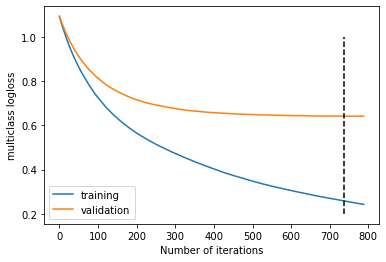

In [35]:
num_epoch = len(best_xgb.evals_result_['validation_0']['mlogloss'])

plt.plot(range(num_epoch), best_xgb.evals_result_['validation_0']['mlogloss'], label = 'training')
plt.plot(range(num_epoch), best_xgb.evals_result_['validation_1']['mlogloss'], label = 'validation')
plt.legend()
plt.plot([best_xgb.best_iteration, best_xgb.best_iteration], [0.2, 1.0], '--k')
plt.xlabel('Number of iterations'); plt.ylabel('multiclass logloss')
plt.show()

## Use the model from the last CV fold to make prediction

In [36]:
predicted_xgb = best_xgb.predict_proba(X_test_std)
print(predicted_xgb.shape)

(619, 3)


## Compare Random Forest and XGBoost

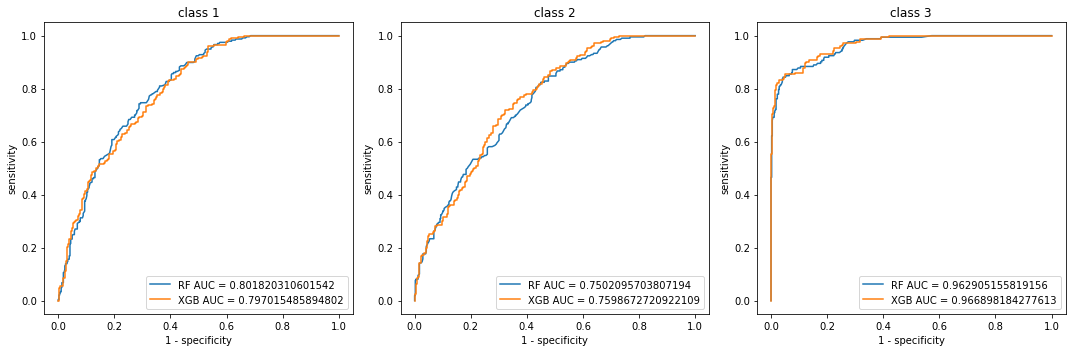

In [37]:
plt.figure(figsize = (15, 5))

for i in range(predicted_rf.shape[1]):
    plt.subplot(1, 3, i + 1)
    fpr, tpr, thresholds = roc_curve(y_test, predicted_rf[:, i], pos_label = (i + 1))
    plt.plot(fpr, tpr, label = 'RF AUC = ' + str(roc_auc_score(y_test == (i + 1), predicted_rf[:, i])))
    
    fpr, tpr, thresholds = roc_curve(y_test, predicted_xgb[:, i], pos_label = (i + 1))
    plt.plot(fpr, tpr, label = 'XGB AUC = ' + str(roc_auc_score(y_test == (i + 1), predicted_xgb[:, i])))
    
    plt.title('class ' + str(i + 1))
    plt.legend(loc = 'lower right')
    plt.xlabel('1 - specificity'); plt.ylabel('sensitivity')

plt.tight_layout()
plt.show()

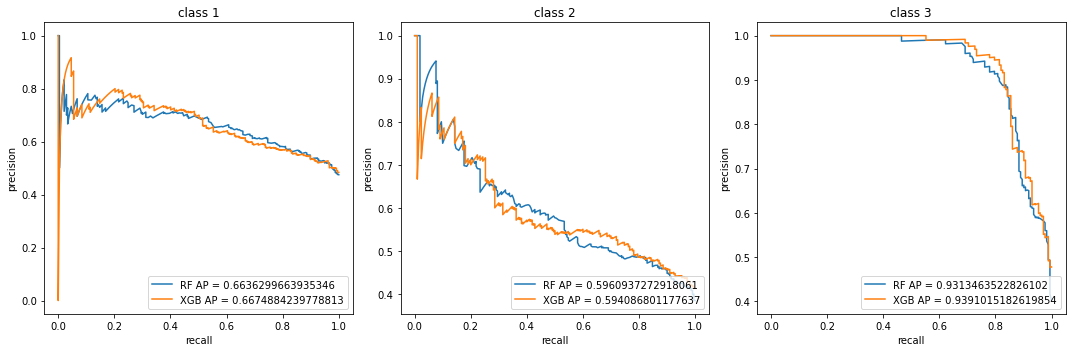

In [38]:
plt.figure(figsize = (15, 5))

for i in range(predicted_rf.shape[1]):
    plt.subplot(1, 3, i + 1)
    precision, recall, thresholds = precision_recall_curve(y_test, predicted_rf[:, i], pos_label = (i + 1))
    plt.plot(recall, precision, label = 'RF AP = ' + str(average_precision_score(y_test == (i + 1), predicted_rf[:, i])))
    
    precision, recall, thresholds = precision_recall_curve(y_test, predicted_xgb[:, i], pos_label = (i + 1))
    plt.plot(recall, precision, label = 'XGB AP = ' + str(average_precision_score(y_test == (i + 1), predicted_xgb[:, i])))
    
    plt.title('class ' + str(i + 1))
    plt.legend(loc = 'lower right')
    plt.xlabel('recall'); plt.ylabel('precision')

plt.tight_layout()
plt.show()

## Visualize data distribution using UMAP
Confirm that class 1 and 2 are difficult to distinguish

In [39]:
umap_model = umap.UMAP(n_neighbors = 100, min_dist = 0.5, random_state = 3011979).fit(X_train_std)
umap_train = umap_model.transform(X_train_std)
umap_test = umap_model.transform(X_test_std)

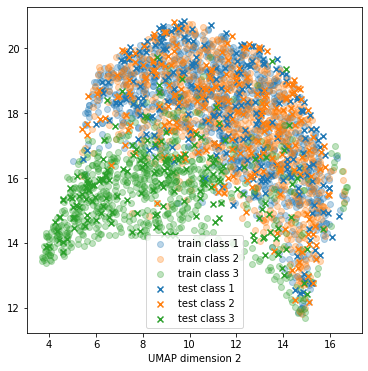

In [40]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize = (6, 6))

for i, cls in enumerate([1, 2, 3]):
    plt.scatter(umap_train[y_train == cls, 0], umap_train[y_train == cls, 1], marker = 'o', c = colors[i], 
                alpha = 0.3, label = 'train class ' + str(cls))
    
for i, cls in enumerate([1, 2, 3]):
    plt.scatter(umap_test[y_test == cls, 0], umap_test[y_test == cls, 1], marker = 'x', c = colors[i], label = 'test class ' + str(cls))

plt.legend()
plt.xlabel('UMAP dimension 1'); plt.xlabel('UMAP dimension 2')
plt.show()